In [4]:
!pip install -r ./requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 KB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

# Libraries

In [60]:
import os
from datasets import Dataset, DatasetDict, Features, Image
import numpy as np
import albumentations as A
import PIL as pil
import matplotlib.pyplot as plt

# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

## Data Loading

In [36]:
def create_data(split_path):
    images = []
    masks = []
    color_dir = os.path.join(split_path, 'color')
    label_dir = os.path.join(split_path, 'label')
    
    # Sort to ensure the pairing order is consistent
    for fname in sorted(os.listdir(color_dir)):
        image_path = os.path.join(color_dir, fname)
        mask_fname = fname.replace("jpg", "png")
        mask_path = os.path.join(label_dir, mask_fname)
        
        images.append(image_path)
        masks.append(mask_path)
        
    return {"image": images, "mask": masks}


In [42]:
features = Features({
    "image": Image(mode="RGB"),
    "mask": Image(mode="RGB")
})

train_val_data = create_data("Dataset/TrainVal")
test_data = create_data("Dataset/Test")

train_val_dataset = Dataset.from_dict(train_val_data, features=features)
test_dataset = Dataset.from_dict(test_data, features=features)




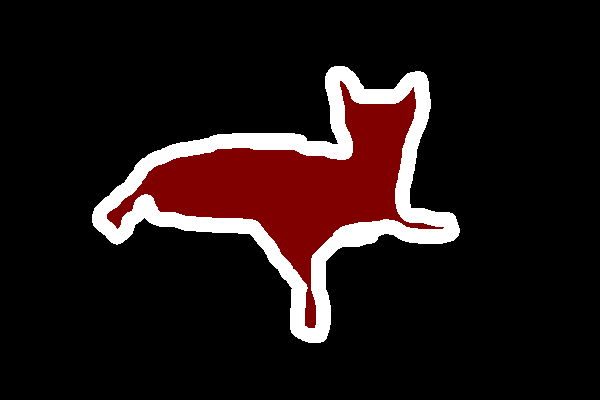

In [43]:
train_val_dataset[0]["mask"]

## Image Augmentations
To prepare for resizing, I will use the smallest width and height image as a baseline for the resized dimensions.

In [44]:
# extract width and height
def extract_dimensions(data):
    width, height = data["image"].size
    return {"width": width, "height": height}

# find min width and height
dim_dataset = train_val_dataset.map(extract_dimensions)
min_w = min(dim_dataset["width"])
min_h = min(dim_dataset["height"])
print((min_h, min_h)) # (108,108)


Map: 100%|██████████| 3680/3680 [00:22<00:00, 166.19 examples/s]

(108, 108)


In [71]:
const_width = 256
const_height = 256

transform = A.Compose([
    A.Resize(height=min_h, width=min_w),       \
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),                   
    A.ColorJitter(p=0.5),                        
], seed=137, strict=True)
 
resize_transform = A.Resize(height=min_h, width=min_w)


In [57]:
def get_apply_transform_fn(augmentation):
    def apply_transform(data):
        image = np.array(data["image"])
        mask = np.array(data["mask"])
        augmented = augmentation(image=image, mask=mask)
        data["image"] = pil.Image.fromarray(augmented["image"])
        data["mask"] = pil.Image.fromarray(augmented["mask"])
        return data
    return apply_transform

aug_transform_fn = get_apply_transform_fn(transform)
resize_transform_fn = get_apply_transform_fn(resize_transform)

aug_train_val_dataset = train_val_dataset.map(aug_transform_fn)
resize_train_val_dataset = train_val_dataset.map(resize_transform_fn)


Map:   0%|          | 0/3680 [00:00<?, ? examples/s]

Map: 100%|██████████| 3680/3680 [00:24<00:00, 152.07 examples/s]


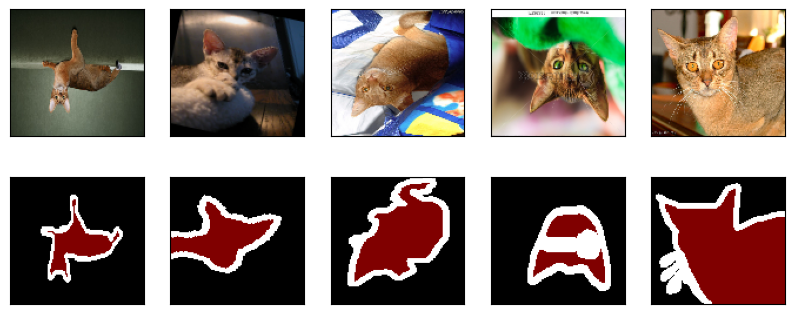

In [82]:
# visualize the transform images
def visualize_transform_images(max, dataset):
    plt.figure(figsize=(10, 4))
    for idx in range(max):
        plt.subplot(2,5,idx+1)
        fig = plt.imshow(dataset[idx]["image"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for idx in range(max):
        plt.subplot(2,5,idx+1+5)
        fig = plt.imshow(dataset[idx]["mask"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

visualize_transform_images(5, aug_train_val_dataset)

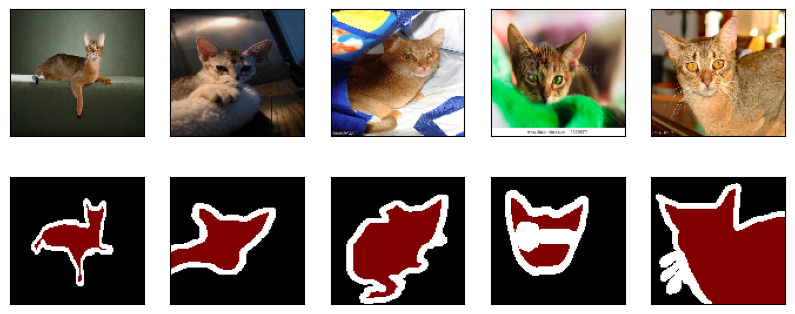

In [83]:
visualize_transform_images(5, resize_train_val_dataset)